In [183]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
from tqdm import tqdm_notebook
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import os
import sys
import time
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
import math


'''Function to create a timeseries data to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 4])
    return np.array(dataX), np.array(dataY)

# get 2011-2018 data to train our model
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2016,12,30)
df = web.DataReader("TSLA", 'yahoo', start, end)


# get 2019 data to test our model on 
start = datetime.datetime(2017,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end)

print(len(df))
print(len(test_df))

# change the dates into ints for training 
train_dates_df = df.copy()
train_dates_df = train_dates_df.reset_index()

test_dates_df = test_df.copy()
test_dates_df = test_dates_df.reset_index()

# convert to ints
train_dates_df['Date'] = train_dates_df['Date'].map(mdates.date2num)
df = train_dates_df  
train_dates_df.tail()

test_dates_df['Date'] = test_dates_df['Date'].map(mdates.date2num)
test_df = test_dates_df
test_dates_df.tail()

1640
841


,Date,High,Low,Open,Close,Volume,Adj Close
836,737545.0,869.820007,763.500000,855.190002,781.880005,28471900,781.880005
837,737546.0,772.770020,683.039978,755.000000,701.320007,32531800,701.320007
838,737549.0,762.000000,698.000000,701.000000,761.190002,19237100,761.190002
839,737550.0,798.919983,762.179993,789.789978,768.210022,16961900,768.210022
840,737551.0,789.799927,761.109985,776.500000,782.580017,11123231,782.580017


In [184]:
train_cols = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']

time_steps = 36
sto_X,sto_Y = create_dataset(df.loc[:,train_cols].values, time_steps)
df.head(37)

,Date,High,Low,Open,Close,Volume,Adj Close
0,733952.0,25.000000,17.540001,19.000000,23.889999,18766300,23.889999
1,733953.0,30.420000,23.299999,25.790001,23.830000,17187100,23.830000
2,733954.0,25.920000,20.270000,25.000000,21.959999,8218800,21.959999
3,733955.0,23.100000,18.709999,23.000000,19.200001,5139800,19.200001
4,733959.0,20.000000,15.830000,20.000000,16.110001,6866900,16.110001
5,733960.0,16.629999,14.980000,16.400000,15.800000,6921700,15.800000
6,733961.0,17.520000,15.570000,16.139999,17.459999,7711400,17.459999
7,733962.0,17.900000,16.549999,17.580000,17.400000,4050600,17.400000
8,733965.0,18.070000,17.000000,17.950001,17.049999,2202500,17.049999
9,733966.0,18.639999,16.900000,17.389999,18.139999,2680100,18.139999


In [185]:
#convert train and test data into normalisation
train_cols = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(df.loc[:,train_cols].values)
test_data = scaler.fit_transform(test_df.loc[:,train_cols].values)

#convert normalised data into timeseries
train_X, train_Y = create_dataset(train_data, time_steps)
test_X,test_Y = create_dataset(test_data, time_steps)

# train_X = np.reshape(train_X, (train_X.shape[0], 36, 7))
# test_X = np.reshape(test_X, (test_X.shape[0], 36, 7))

#normalise entire train data and test data seperately
# print(scaler.inverse_transform([train_Y]))

# scaler_new = MinMaxScaler(feature_range=(-1, 1))

# dat = scaler.
close_col= ['Close']
new_train_data = scaler.fit_transform(df.loc[:,close_col].values)
                                      
print(df.head())
print(new_train_data[36:])
print(train_Y)

# print(sto_Y)
print(scaler.inverse_transform([train_Y]))

# close_cols = ['Close']
# scaler_new = MinMaxScaler(feature_range=(-1, 1))
# new_train_data = scaler.fit_transform(np.reshape(sto_Y,(sto_Y.shape[0],1)))
# print(new_train_data)
# print(train_Y)

       Date   High        Low       Open      Close    Volume  Adj Close
0  733952.0  25.00  17.540001  19.000000  23.889999  18766300  23.889999
1  733953.0  30.42  23.299999  25.790001  23.830000  17187100  23.830000
2  733954.0  25.92  20.270000  25.000000  21.959999   8218800  21.959999
3  733955.0  23.10  18.709999  23.000000  19.200001   5139800  19.200001
4  733959.0  20.00  15.830000  20.000000  16.110001   6866900  16.110001
[[-0.97787152]
 [-0.97557726]
 [-0.96795442]
 ...
 [ 0.50932504]
 [ 0.47187675]
 [ 0.46455   ]]
[-0.97787152 -0.97557726 -0.96795442 ...  0.50932504  0.47187675
  0.46455   ]
[[ 18.79000092  19.10000038  20.12999916 ... 219.74000549 214.67999268
  213.69000244]]


In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras import optimizers
model = Sequential()
model.add(LSTM(100, input_shape = (train_X.shape[1], 7), return_sequences = True))
model.add(LSTM(60))
model.add(Dropout(0.5))
model.add(Dense(1,activation='tanh'))

# MODEL COMPILING AND TRAINING
# sgd = optimizers.SGD(lr=1e-3)
adam = optimizers.Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam) # Try SGD, adam, adagrad and compare!!!
history = model.fit(train_X, train_Y, epochs=100, batch_size=10)

Train on 1604 samples
Epoch 1/100
1604/1604 [==============================] - ETA: 30:04 - loss: 0.39 - ETA: 15:03 - loss: 0.33 - ETA: 10:02 - loss: 0.25 - ETA: 7:32 - loss: 0.2107 - ETA: 6:01 - loss: 0.175 - ETA: 5:01 - loss: 0.148 - ETA: 4:18 - loss: 0.133 - ETA: 3:45 - loss: 0.123 - ETA: 3:20 - loss: 0.113 - ETA: 3:00 - loss: 0.118 - ETA: 2:44 - loss: 0.115 - ETA: 2:30 - loss: 0.110 - ETA: 2:18 - loss: 0.105 - ETA: 2:08 - loss: 0.099 - ETA: 2:00 - loss: 0.097 - ETA: 1:52 - loss: 0.091 - ETA: 1:45 - loss: 0.087 - ETA: 1:39 - loss: 0.082 - ETA: 1:34 - loss: 0.080 - ETA: 1:29 - loss: 0.077 - ETA: 1:25 - loss: 0.074 - ETA: 1:21 - loss: 0.071 - ETA: 1:17 - loss: 0.068 - ETA: 1:14 - loss: 0.066 - ETA: 1:11 - loss: 0.064 - ETA: 1:08 - loss: 0.062 - ETA: 1:05 - loss: 0.060 - ETA: 1:03 - loss: 0.058 - ETA: 1:01 - loss: 0.057 - ETA: 59s - loss: 0.055 - ETA: 57s - loss: 0.05 - ETA: 55s - loss: 0.05 - ETA: 53s - loss: 0.05 - ETA: 51s - loss: 0.05 - ETA: 50s - loss: 0.04 - ETA: 48s - loss: 0.04

1604/1604 [==============================] - ETA: 9s - loss: 0.003 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0081 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 16s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0074 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0051 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0055 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0050 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0041 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.01 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0040 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 12s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0052 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0038 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0052 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.003 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0030 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0035 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0033 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0040 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0029 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0028 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0043 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0037 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.02 - ETA: 16s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0043 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0029 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0033 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0034 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0039 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0026 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0028 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0026 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 10s - loss: 9.4338e- - ETA: 10s - loss: 9.5462e- - ETA: 10s - loss: 0.0015   - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0028 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0037 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0027 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 9.0943e- - ETA: 11s - loss: 0.0017   - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0028 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - 

1604/1604 [==============================] - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.

1604/1604 [==============================] - ETA: 11s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0032 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.

1604/1604 [==============================] - ETA: 6s - loss: 4.8401e-0 - ETA: 6s - loss: 0.0021    - ETA: 6s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - l

Epoch 74/100
1604/1604 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4

1604/1604 [==============================] - ETA: 19s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0031 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0031 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0

1604/1604 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.0

1604/1604 [==============================] - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.0

1604/1604 [==============================] - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.0

1604/1604 [==============================] - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.0

1604/1604 [==============================] - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0022 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.003 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0033 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0

1604/1604 [==============================] - ETA: 9s - loss: 0.023 - ETA: 9s - loss: 0.011 - ETA: 9s - loss: 0.008 - ETA: 9s - loss: 0.007 - ETA: 9s - loss: 0.006 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.0

1604/1604 [==============================] - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0033 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.

1604/1604 [==============================] - ETA: 8s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.0

1604/1604 [==============================] - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.004 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.0

1604/1604 [==============================] - ETA: 9s - loss: 0.006 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.004 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 9s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 8s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.0

In [193]:
trainPredict =  model.predict(train_X)
print(trainPredict)
print(train_Y)
print(scaler.inverse_transform(trainPredict))

[[-0.9666622 ]
 [-0.9664359 ]
 [-0.96662474]
 ...
 [ 0.5216838 ]
 [ 0.5186248 ]
 [ 0.48365408]]
[-0.97787152 -0.97557726 -0.96795442 ...  0.50932504  0.47187675
  0.46455   ]
[[ 20.3046  ]
 [ 20.33518 ]
 [ 20.309666]
 ...
 [221.40993 ]
 [220.99658 ]
 [216.27135 ]]


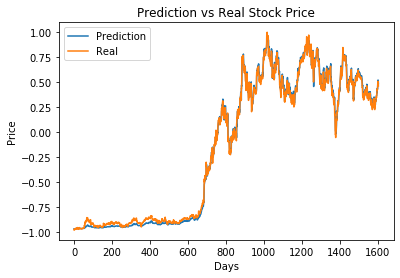

In [194]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(trainPredict)
plt.plot(train_Y)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [195]:
testPredict = model.predict(test_X)
print(testPredict)
print(test_Y)

[[-0.86759335]
 [-0.8855109 ]
 [-0.90328497]
 [-0.91383815]
 [-0.9158875 ]
 [-0.91334784]
 [-0.9116114 ]
 [-0.9098047 ]
 [-0.9104499 ]
 [-0.91142446]
 [-0.9146066 ]
 [-0.9171767 ]
 [-0.91767377]
 [-0.90749156]
 [-0.902159  ]
 [-0.8891222 ]
 [-0.8832784 ]
 [-0.8855587 ]
 [-0.8918677 ]
 [-0.89682126]
 [-0.90330565]
 [-0.8955375 ]
 [-0.88408494]
 [-0.86374444]
 [-0.85201514]
 [-0.8487827 ]
 [-0.8516099 ]
 [-0.8176185 ]
 [-0.79304534]
 [-0.79115564]
 [-0.79370785]
 [-0.8020809 ]
 [-0.7828474 ]
 [-0.7662914 ]
 [-0.7733473 ]
 [-0.7764081 ]
 [-0.7970105 ]
 [-0.80391616]
 [-0.79421854]
 [-0.7834636 ]
 [-0.7750959 ]
 [-0.7712612 ]
 [-0.7624765 ]
 [-0.7645331 ]
 [-0.76538384]
 [-0.7597491 ]
 [-0.73766124]
 [-0.7304902 ]
 [-0.7334582 ]
 [-0.76129943]
 [-0.7795589 ]
 [-0.78238267]
 [-0.7498491 ]
 [-0.72705764]
 [-0.7148256 ]
 [-0.7151425 ]
 [-0.73060495]
 [-0.743965  ]
 [-0.7546712 ]
 [-0.7571811 ]
 [-0.7599027 ]
 [-0.75651747]
 [-0.7646312 ]
 [-0.7617724 ]
 [-0.7528336 ]
 [-0.72655964]
 [-0.69233

 [ 0.6165487 ]]
[-0.78866545 -0.81783466 -0.80765114 -0.8075699  -0.80632407 -0.80337191
 -0.80434692 -0.8114429  -0.81610131 -0.82143681 -0.82471392 -0.81799716
 -0.78595707 -0.79210509 -0.77498818 -0.77647776 -0.7753402  -0.8057824
 -0.79405513 -0.79467804 -0.77198184 -0.75286072 -0.73327913 -0.73346874
 -0.73200619 -0.73097708 -0.67621372 -0.66218427 -0.68574717 -0.67572615
 -0.66532599 -0.63864848 -0.64861536 -0.68076377 -0.66137179 -0.66830522
 -0.6715282  -0.65725509 -0.66540724 -0.65703837 -0.65045704 -0.63485677
 -0.64466107 -0.64883199 -0.63409842 -0.61037311 -0.62104403 -0.64235902
 -0.68450134 -0.64959034 -0.65273206 -0.6146252  -0.60390005 -0.60964179
 -0.6050105  -0.62919627 -0.62613579 -0.65565715 -0.63683391 -0.64287362
 -0.64417358 -0.661751   -0.64452569 -0.62662336 -0.60411668 -0.57714129
 -0.56113478 -0.56286818 -0.5642765  -0.54404493 -0.52906762 -0.51065069
 -0.48261899 -0.51696117 -0.51238401 -0.46650412 -0.45374769 -0.46815627
 -0.47882728 -0.4831607  -0.47655225

  0.63480271]


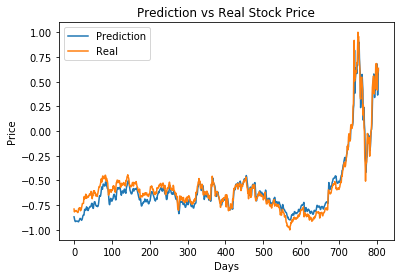

Train RMSE: 0.04
0.03759250708850171
Test RMSE: 0.07
0.07483708220245222
r2 value: 0.95
0.9480935529810095


In [196]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(testPredict)
plt.plot(test_Y)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(train_Y,trainPredict))
print('Train RMSE: %.2f' % (trainScore))
print(trainScore)

# TEST RMSE
testScore = math.sqrt(mean_squared_error(test_Y, testPredict))
print('Test RMSE: %.2f' % (testScore))
print(testScore)

r = r2_score(test_Y,testPredict)
print('r2 value: %.2f'% (r))
print(r)

In [199]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 36, 100)           43200     
_________________________________________________________________
lstm_29 (LSTM)               (None, 60)                38640     
_________________________________________________________________
dropout_22 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 61        
Total params: 81,901
Trainable params: 81,901
Non-trainable params: 0
_________________________________________________________________


0.7171471032461605


In [200]:
train_X.shape

(1604, 36, 7)

In [201]:
print (df['Adj Close'].pct_change())

0            NaN
1      -0.002511
2      -0.078473
3      -0.125683
4      -0.160938
          ...   
1635    0.023459
1636    0.029015
1637    0.000957
1638   -0.023027
1639   -0.004611
Name: Adj Close, Length: 1640, dtype: float64


In [206]:
dataset = df
dataset['Buy_Sell_on_Open'] = np.where(df['Open'].shift(-1) > df['Open'],1,0)
# dataset['Buy_Sell'] = np.where(df['Adj Close'].shift(-1) > df['Adj Close'],1,0)
# dataset['Increase_Decrease'] = np.where(df['Volume'].shift(-1) > df['Volume'],'Increase','Decrease')
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset['Average'] = dataset[['Open','High','Low','Adj Close']].mean(axis=1)
dataset['Std'] = dataset[['Open','High','Low','Adj Close']].std(axis=1)


In [211]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2016,12,30)
df = web.DataReader("TSLA", 'yahoo', start, end)
df['Buy_Sell_on_Open'] = np.where(df['Open'].shift(-1) > df['Open'],1,0)
df['Returns'] = df['Adj Close'].pct_change()
df['Average'] = df[['Open','High','Low','Adj Close']].mean(axis=1)
df['Std'] = df[['Open','High','Low','Adj Close']].std(axis=1)
print(df.head(5))

             High        Low       Open      Close    Volume  Adj Close  \
Date                                                                      
2010-06-29  25.00  17.540001  19.000000  23.889999  18766300  23.889999   
2010-06-30  30.42  23.299999  25.790001  23.830000  17187100  23.830000   
2010-07-01  25.92  20.270000  25.000000  21.959999   8218800  21.959999   
2010-07-02  23.10  18.709999  23.000000  19.200001   5139800  19.200001   
2010-07-06  20.00  15.830000  20.000000  16.110001   6866900  16.110001   

            Buy_Sell_on_Open   Returns  Average       Std  
Date                                                       
2010-06-29                 1       NaN  21.3575  3.642914  
2010-06-30                 0 -0.002511  25.8350  3.238853  
2010-07-01                 0 -0.078473  23.2875  2.628705  
2010-07-02                 0 -0.125683  21.0025  2.373049  
2010-07-06                 0 -0.160938  17.9850  2.329528  


In [208]:
print(df)

          Date        High         Low        Open       Close    Volume  \
0     733952.0   25.000000   17.540001   19.000000   23.889999  18766300   
1     733953.0   30.420000   23.299999   25.790001   23.830000  17187100   
2     733954.0   25.920000   20.270000   25.000000   21.959999   8218800   
3     733955.0   23.100000   18.709999   23.000000   19.200001   5139800   
4     733959.0   20.000000   15.830000   20.000000   16.110001   6866900   
...        ...         ...         ...         ...         ...       ...   
1635  736321.0  213.449997  207.710007  208.000000  213.339996   4670500   
1636  736325.0  222.250000  214.419998  214.880005  219.529999   5915700   
1637  736326.0  223.800003  217.199997  221.529999  219.740005   3782500   
1638  736327.0  219.199997  214.119995  218.559998  214.679993   4045000   
1639  736328.0  217.500000  211.679993  216.300003  213.690002   4642600   

       Adj Close  Buy_Sell_on_Open  Buy_Sell Increase_Decrease  
0      23.889999      